# Notebook for anlaysing the structure of the social network.

This uses data from simulation batches run using release v1.0 of the model.

## TODO:
- colour nodes by OVR
- plot degree against OVR
- produce table of summary stats for graphs with different projects per timestep.
- plots stats versus pp_ts
- plot and interpret excess degree distribution

In [93]:
DATA_DIR = '../simulation_io/project_per_step_1_230521_v1.0/'
TS = 90

In [94]:
import pickle
import collections
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import os, sys
MODEL_DIR = os.path.realpath(os.path.dirname('../superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))
from superscript_model import model

In [95]:
sim_type = 'Basin_w_flex'

with open(DATA_DIR + sim_type + '/network_timestep_%d.gpickle' % TS, 'rb') as ifile:
    G = nx.read_gpickle(ifile) 

With 2 projects per timetsep there is a strongly connected component and many isolated nodes:

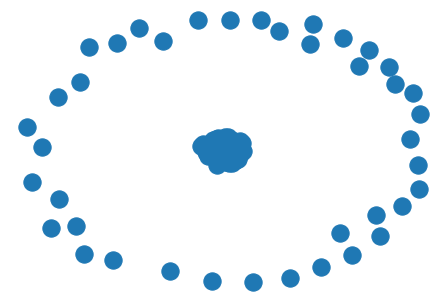

In [96]:
nx.draw(G)

In [97]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

There are many 'connected components' detected:

In [98]:
len(S)

41

But only one of these contains more than one node:

In [99]:
[len(si) for si in S if len(si) > 1]

[64]

This is the connected core of workers that have successfully collaborated on project:

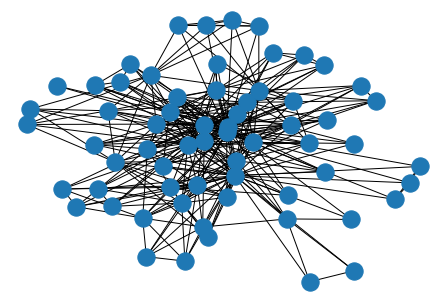

In [100]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
nx.draw(largest_cc)

In [101]:
edges = largest_cc.edges()
weights = [G[u][v]['weight'] for u,v in edges]

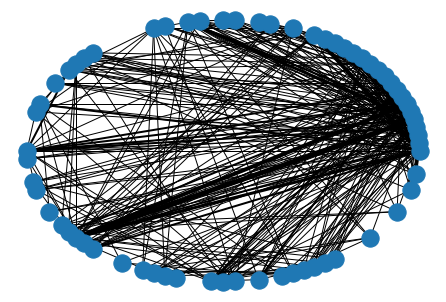

In [102]:
nx.draw(largest_cc, width=weights, pos=nx.circular_layout(G))

With 10 projects per timestep there are fewer isolates:

In [103]:
DATA_DIR = '../simulation_io/project_per_step_10_230521_v1.0/'
TS = 30

In [104]:
sim_type = 'Basin_w_flex'

with open(DATA_DIR + sim_type + '/network_timestep_%d.gpickle' % TS, 'rb') as ifile:
    G = nx.read_gpickle(ifile) 

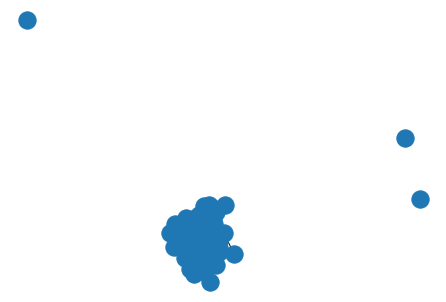

In [105]:
nx.draw(G)

In [106]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

Most of the workers are in the large connected component:

In [107]:
[len(si) for si in S if len(si) > 1]

[97]

This is the connected core of workers that have successfully collaborated on project:

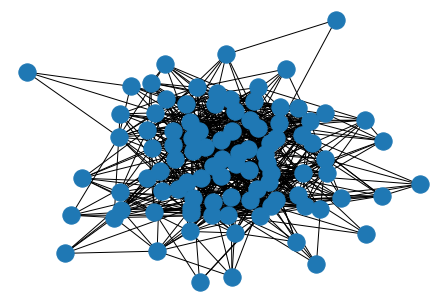

In [108]:
largest_cc = G.subgraph(max(nx.connected_components(G), key=len))
nx.draw(largest_cc)

In [109]:
edges = largest_cc.edges()
weights = [G[u][v]['weight'] for u,v in edges]

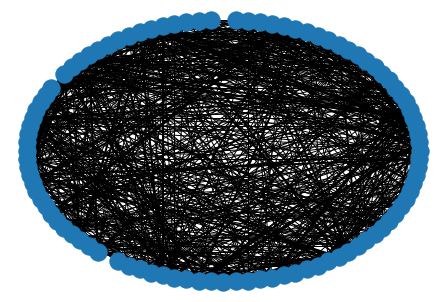

In [110]:
nx.draw(largest_cc, width=weights, pos=nx.circular_layout(G))

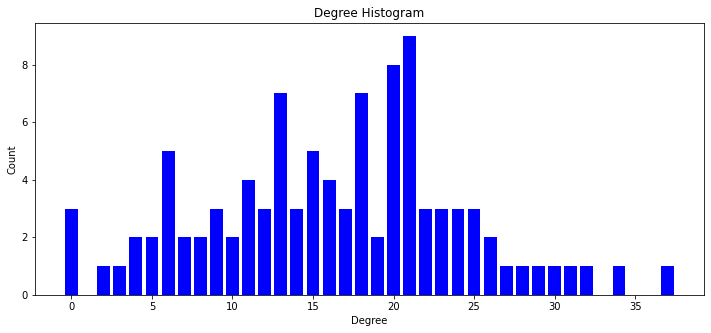

In [111]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig = plt.figure(figsize=(12,5))
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg);

In [116]:
nx.classes.function.density(G) ## aka connectance

0.16444444444444445

In [117]:
nx.classes.function.info(G) 

'Name: \nType: Graph\nNumber of nodes: 100\nNumber of edges: 814\nAverage degree:  16.2800'

In [118]:
nx.classes.function.number_of_edges(G) 

814

In [126]:
np.mean(list(dict(nx.classes.function.degree(G)).values()))

16.28

In [127]:
nx.classes.function.number_of_selfloops(G) 

0

In [146]:
nx.algorithms.isolate.number_of_isolates(G)

3

In [148]:
nx.algorithms.assortativity.degree_assortativity_coefficient(G)

0.034596508242882865

In [151]:
# diameter of largest_cc
nx.algorithms.distance_measurbes.diameter(G.subgraph(max(nx.connected_components(G), key=len)))

4

In [156]:
nx.non_randomness(G.subgraph(max(nx.connected_components(G), key=len)))

(24.859716863541077, 13.49917990496426)

In [158]:
nx.wiener_index(G.subgraph(max(nx.connected_components(G), key=len)))

9205.0

In [164]:
np.mean(list(nx.average_neighbor_degree(G).values()))

19.26525248302556

# Which metrics to compute for full graph and which for largest cc?

In [141]:
from networkx.algorithms.approximation import (
    large_clique_size, 
    average_clustering,
    treewidth_min_degree
)

In [138]:
large_clique_size(G)

7

In [140]:
average_clustering(G)

0.446

In [143]:
treewidth_min_degree(G)[0]

48

In [172]:
nx.classes.function.number_of_nodes(G)

100

In [192]:
def compute_network_metrics(network_dict, metric_dict=None):
    
    def load_net(n): 
        with open(n, 'rb') as ifile:
            return nx.read_gpickle(ifile) 
        
    network_dict = {
        key: load_net(network_dict[key])
        for key in network_dict.keys()
    }
    
    results = pd.DataFrame()
    results['network'] = network_dict.keys()
    
    if metric_dict is None:
        metric_dict = {
            
            'number_of_isolates': nx.algorithms.isolate.number_of_isolates,
            'number_of_edges': nx.classes.function.number_of_edges,
            'mean_degree': lambda x: np.mean(list(dict(nx.classes.function.degree(x)).values())),
            'density': nx.classes.function.density,
            'clustering_coefficient': average_clustering,
            'assortativity': nx.algorithms.assortativity.degree_assortativity_coefficient,
            'treewidth': lambda x: treewidth_min_degree(G)[0],
            'size_of_largest_connected_cpt': lambda x: nx.classes.function.number_of_nodes(x.subgraph(max(nx.connected_components(G), key=len))),
            'size_of_largest_clique': large_clique_size,
            'mean_excess_degree': lambda x: np.mean(list(nx.average_neighbor_degree(x).values())),
            'non-randomness_lcc': lambda x: nx.non_randomness(x.subgraph(max(nx.connected_components(x), key=len))),
            'diameter_lcc': lambda x: nx.algorithms.distance_measures.diameter(x.subgraph(max(nx.connected_components(x), key=len)))
            
        }
        
    for metric in metric_dict.keys():
        results[metric] = [metric_dict[metric](G) for G in network_dict.values()]
    
    return results

In [200]:
TS = 90
sim_type = 'Basin_w_flex'

net_metrics = compute_network_metrics({
    'projects = 1': '../simulation_io/project_per_step_1_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 2': '../simulation_io/project_per_step_2_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 3': '../simulation_io/project_per_step_3_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 5': '../simulation_io/project_per_step_5_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,    
    'projects = 10': '../simulation_io/project_per_step_10_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
})

sim_type = 'Random'

net_metrics_random = compute_network_metrics({
    'projects = 1': '../simulation_io/project_per_step_1_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 2': '../simulation_io/project_per_step_2_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 3': '../simulation_io/project_per_step_3_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
    'projects = 5': '../simulation_io/project_per_step_5_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,    
    'projects = 10': '../simulation_io/project_per_step_10_230521_v1.0/' + sim_type + '/network_timestep_%d.gpickle' % TS,
})

In [194]:
net_metrics

,network,number_of_isolates,number_of_edges,mean_degree,density,clustering_coefficient,assortativity,treewidth,size_of_largest_connected_cpt,size_of_largest_clique,mean_excess_degree,non-randomness_lcc,diameter_lcc
0,projects = 1,40,339,6.519231,0.063294,0.467,-0.214308,48,10,8,11.381181,"(29.286586577084062, 33.76872858081157)",3
1,projects = 2,18,619,12.257426,0.122574,0.567,-0.158910,48,22,10,19.693384,"(45.852331628003796, 55.20791179493717)",3
2,projects = 3,5,885,17.700000,0.178788,0.605,-0.154589,48,32,12,28.010421,"(56.836882837367405, 66.34461847219573)",3
3,projects = 5,1,1466,29.320000,0.296162,0.559,-0.077651,48,63,14,37.355688,"(84.29310985161092, 24.899346895395382)",4
4,projects = 10,0,2480,49.600000,0.501010,0.553,-0.028799,48,97,12,51.845567,"(85.06804804374694, 49.45381720769174)",2


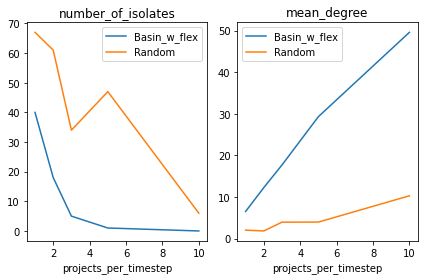

In [208]:
X = [1,2,3,5,10]

def splot(metric):    
    plt.plot(X, net_metrics[metric], label='Basin_w_flex')
    plt.plot(X, net_metrics_random[metric], label='Random')
    plt.legend()
    plt.xlabel('projects_per_timestep')
    plt.title(metric)
    
plt.subplot(1,2,1)
splot('number_of_isolates')
plt.subplot(1,2,2)
splot('mean_degree')
plt.tight_layout()